# Table of Contents
* [Evaluation overview](#evaluation)
* [Latest Results](#latest-results)
* [Evaluation metrics](#evaluation-metrics)
  * [Relevance](#relevance)
  * [Readability](#readability)
  * [Factuality](#factuality)
* [Info from 2024](#official-evaluation-pipline-from-2024)

## Evaluation <a class="ahchor" id="eval"></a>

We have two goals with the evaluation portion:
1. Have a working evaluation that gives reasonable results
   * Now that it is open, we will use the task [codabench](https://www.codabench.org/competitions/7351/)
   * We can run up to 10 evals a day with a task maximum of 100. Each run can take 4+ hours.
2. Understand how all of the evaluation metrics work and what the results mean
   * We're doing this by re-creating the [pipeline from 2024](https://github.com/TGoldsack1/BioLaySumm2024-evaluation_scripts) and running it locally. 
   * The code had some issues when installed locally due to conflicting dependencies, missing checkpoints, and unequal file sizes. Dependencies were corrected by creating a very specific environment, missing checkpoints were fixed by using a different set of LENS checkpoints, and unequal file sizes were address by using the minimum length of the two files.
3. When we do evaluations locally, we are using the training data. When we use codabench, we are sending the test data per the requirements of the task. 

In [ ]:
import pandas as pd

def display_custom_table(file_path, caption=None):
    """
    Load a table from a CSV file and display it with:
    - Pink header (#f888b9)
    - Alternating light/mid blue rows
    - Black text
    - Bold top two rows and first column
    - Border around the table
    """

    # Load the CSV
    df = pd.read_csv(file_path)

    # Save original "pretty" headers
    pretty_columns = [col if not col.startswith("Unnamed") else "" for col in df.columns]

    # Fix for Styler: make internal columns unique
    safe_columns = []
    seen = {}
    for col in pretty_columns:
        key = col if col != "" else "<empty>"
        if key not in seen:
            seen[key] = 1
            safe_columns.append(key)
        else:
            seen[key] += 1
            safe_columns.append(f"{key}_{seen[key]}")
    df.columns = safe_columns

    # Replace NaN with empty strings
    df = df.fillna("")

    # Create the Styler
    styler = df.style.hide(axis="index")

    if caption:
        styler = styler.set_caption(caption)

    # Set table outline, header color (YOUR pink), black text
    styler = styler.set_table_styles([
        {'selector': 'table', 'props': [('border', '2px solid black'), ('border-collapse', 'collapse')]},
        {'selector': 'thead th', 'props': [('background-color', '#f888b9'), ('color', 'black'), ('font-weight', 'bold'), ('border', '1px solid black')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid black'), ('color', 'black')]},
    ])

    # Default all cells to light blue + black text
    styler = styler.set_properties(**{
        'background-color': '#add8e6',
        'color': 'black'
    })

    # Apply alternating row colors
    def highlight_rows(row):
        color = '#87ceeb' if row.name % 2 else '#add8e6'
        return [f'background-color: {color}; color: black;' for _ in row]

    styler = styler.apply(highlight_rows, axis=1)

    # --- Bold the top two rows ---
    def bold_top_two_rows(row):
        if row.name in [0, 1]:  # First two rows
            return ['font-weight: bold;' for _ in row]
        else:
            return ['' for _ in row]

    styler = styler.apply(bold_top_two_rows, axis=1)

    # --- Bold the first column ---
    def bold_first_column(val):
        return 'font-weight: bold;'

    first_column_name = df.columns[0]
    styler = styler.applymap(bold_first_column, subset=[first_column_name])

    # Set display headers back to pretty
    styler.columns = pretty_columns

    display(styler)


In [25]:

display_custom_table('results.csv')

,_2,Relevance,_3,_4,_5,_6,_7,Readability,_8,_9,_10,Factuality,_11
Date,Where,ROUGE1,ROUGE2,ROUGEL,BLEU,METEOR,BERTScore,FKGL,DCRS,CLI,LENS,AlignScore,SummaC
Best,,48.72,15.69,45.5,x,x,86.77,10.46,6.76,11.04,81.21,93.08,90.28
Worst,,25.64,4.03,23.18,x,x,80.63,36.29,12.45,18.98,1.32,42.41,44.61
25-Apr,Codabench,failed,,,,,,,,,,,
25-Apr,local,11.26,1.91,10.8,,,80.06,15.4339,8.3134,4.9358,,,
27-Apr,Codabench,pending,,,,,,,,,,,



### Evaluation metrics



#### Relevance

**ROUGE (1, 2, and L)**
<div style="padding-left: 2em;">
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) includes measures to automatically determine the quality of a summary by
comparing it to other (ideal) summaries created by humans. The measures count the number of overlapping units such as n-gram, word sequences, and
word pairs between the computer-generated summary to be evaluated and the ideal summaries created by humans.
<br><br>
ROUGE 1 and 2 variations of ROUGE-N using n-gram lengths of 1 and 2. ROUGE-L uses the longest common subsequence between the two summaries.

Lin, C.-Y. (2004). ROUGE: A Package for Automatic Evaluation of Summaries. https://aclanthology.org/W04-1013.pdf
</div>

**BLEU**
<div style="padding-left: 2em;">
BLEU (Bilingual Evaluation Understudy) is a measurement of an automatic translation and a human written translation of the same material. Nearly universally disliked, but no one has developed a method that is better while still as light and easy to use. Compares consecutive phrases of the automatic translation with the consecutive phrases it finds in the reference translation, and counts the number of matches, in a weighted fashion. Matches are position independent. Intelligibility and grammatical correctness aren't taken into account. Adds a brevity penalty for text segments that are short.

Kishore Papineni, Salim Roukos, Todd Ward, and Wei-Jing Zhu. 2002. BLEU: a method for automatic evaluation of machine translation. In Proceedings of the 40th Annual Meeting on Association for Computational Linguistics (ACL '02). Association for Computational Linguistics, USA, 311–318. https://doi.org/10.3115/1073083.1073135
</div>

**METEOR** ☄️

<div style="padding-left: 2em;">

METEOR (Metric for Evaluation of Translation with Explicit ORdering) is based on the harmonic mean of unigram precision and recall, with recall weighted higher than precision. It includes stemming and synonymy matching, along with the standard exact word matching. 

Banerjee, S., & Lavie, A. (2005). METEOR: An Automatic Metric for MT Evaluation with Improved Correlation with Human Judgments. https://aclanthology.org/W05-0909.pdf
‌</div>

**BERTScore**  <img src="images/bert.jpg" alt="BERTScore Visualization" width="100" />

<div style="padding-left: 2em;">

A neural evaluation metric that uses contextual embeddings from pre-trained language models (like BERT) to calculate similarity scores between candidate and reference texts.

Zhang, T., Kishore, V., Wu, F., Weinberger, K., & Artzi, Y. (n.d.). BERTSCORE: EVALUATING TEXT GENERATION WITH BERT. https://arxiv.org/pdf/1904.09675

‌

</div>


#### Readability

For these, lower is better.

**Flesch-Kincaid Grade Level (FKGL)**
<div style="padding-left: 2em;">
Used to evaluate the readability of English text. Result is given in a score that is equivalent to grade level in US schools - 12+ is college and graduate school.

$$
\text{Flesch-Kincaid Grade Level} = 0.39 \times \left( \frac{\text{total words}}{\text{total sentences}} \right) + 11.8 \times \left( \frac{\text{total syllables}}{\text{total words}} \right) - 15.59
$$
</div>

**Dale-Chall Readability Score (DCRS)**

<div style="padding-left: 2em;">
Starts with a list of 3000 words that are considered difficult for an (american?) fourth grader. Result is given in US grade level.

$$
\text{Dale-Chall Score} = 0.1579 \times \left( \frac{\text{difficult words}}{\text{total words}} \times 100 \right) + 0.0496 \times \left( \frac{\text{total words}}{\text{total sentences}} \right)
$$
</div>

**Coleman-Liau Index (CLI)**

<div style="padding-left: 2em;">
Similiar to the others, but relies on characters in word instead of syllables per word.

$$
\text{CLI} = 0.0588 \times \left( \frac{\text{total letters}}{\text{total words}} \times 100 \right) - 0.296 \times \left( \frac{\text{total sentences}}{\text{total words}} \times 100 \right) - 15.8
$$
</div>



**LENS**



#### Factuality

**AlignScore**

**SummaC**

The LENS checkpoints included in the 2024 evaluation no longer work. I replaced them with the checkpoints from https://huggingface.co/davidheineman/lens.

### BioLaySumm Task 1.1 evaluation

Each evaluation aspect will be composed of one or more automatic metrics:

**Relevance** - ROUGE (1, 2, and L), BLEU, METEOR, BERTScore

**Readability** - Flesch-Kincaid Grade Level (FKGL) and Dale-Chall Readability Score (DCRS), Coleman-Liau Index (CLI), and LENS

**Factuality** - AlignScore, SummaC

***

### Official evaluation pipline from 2024

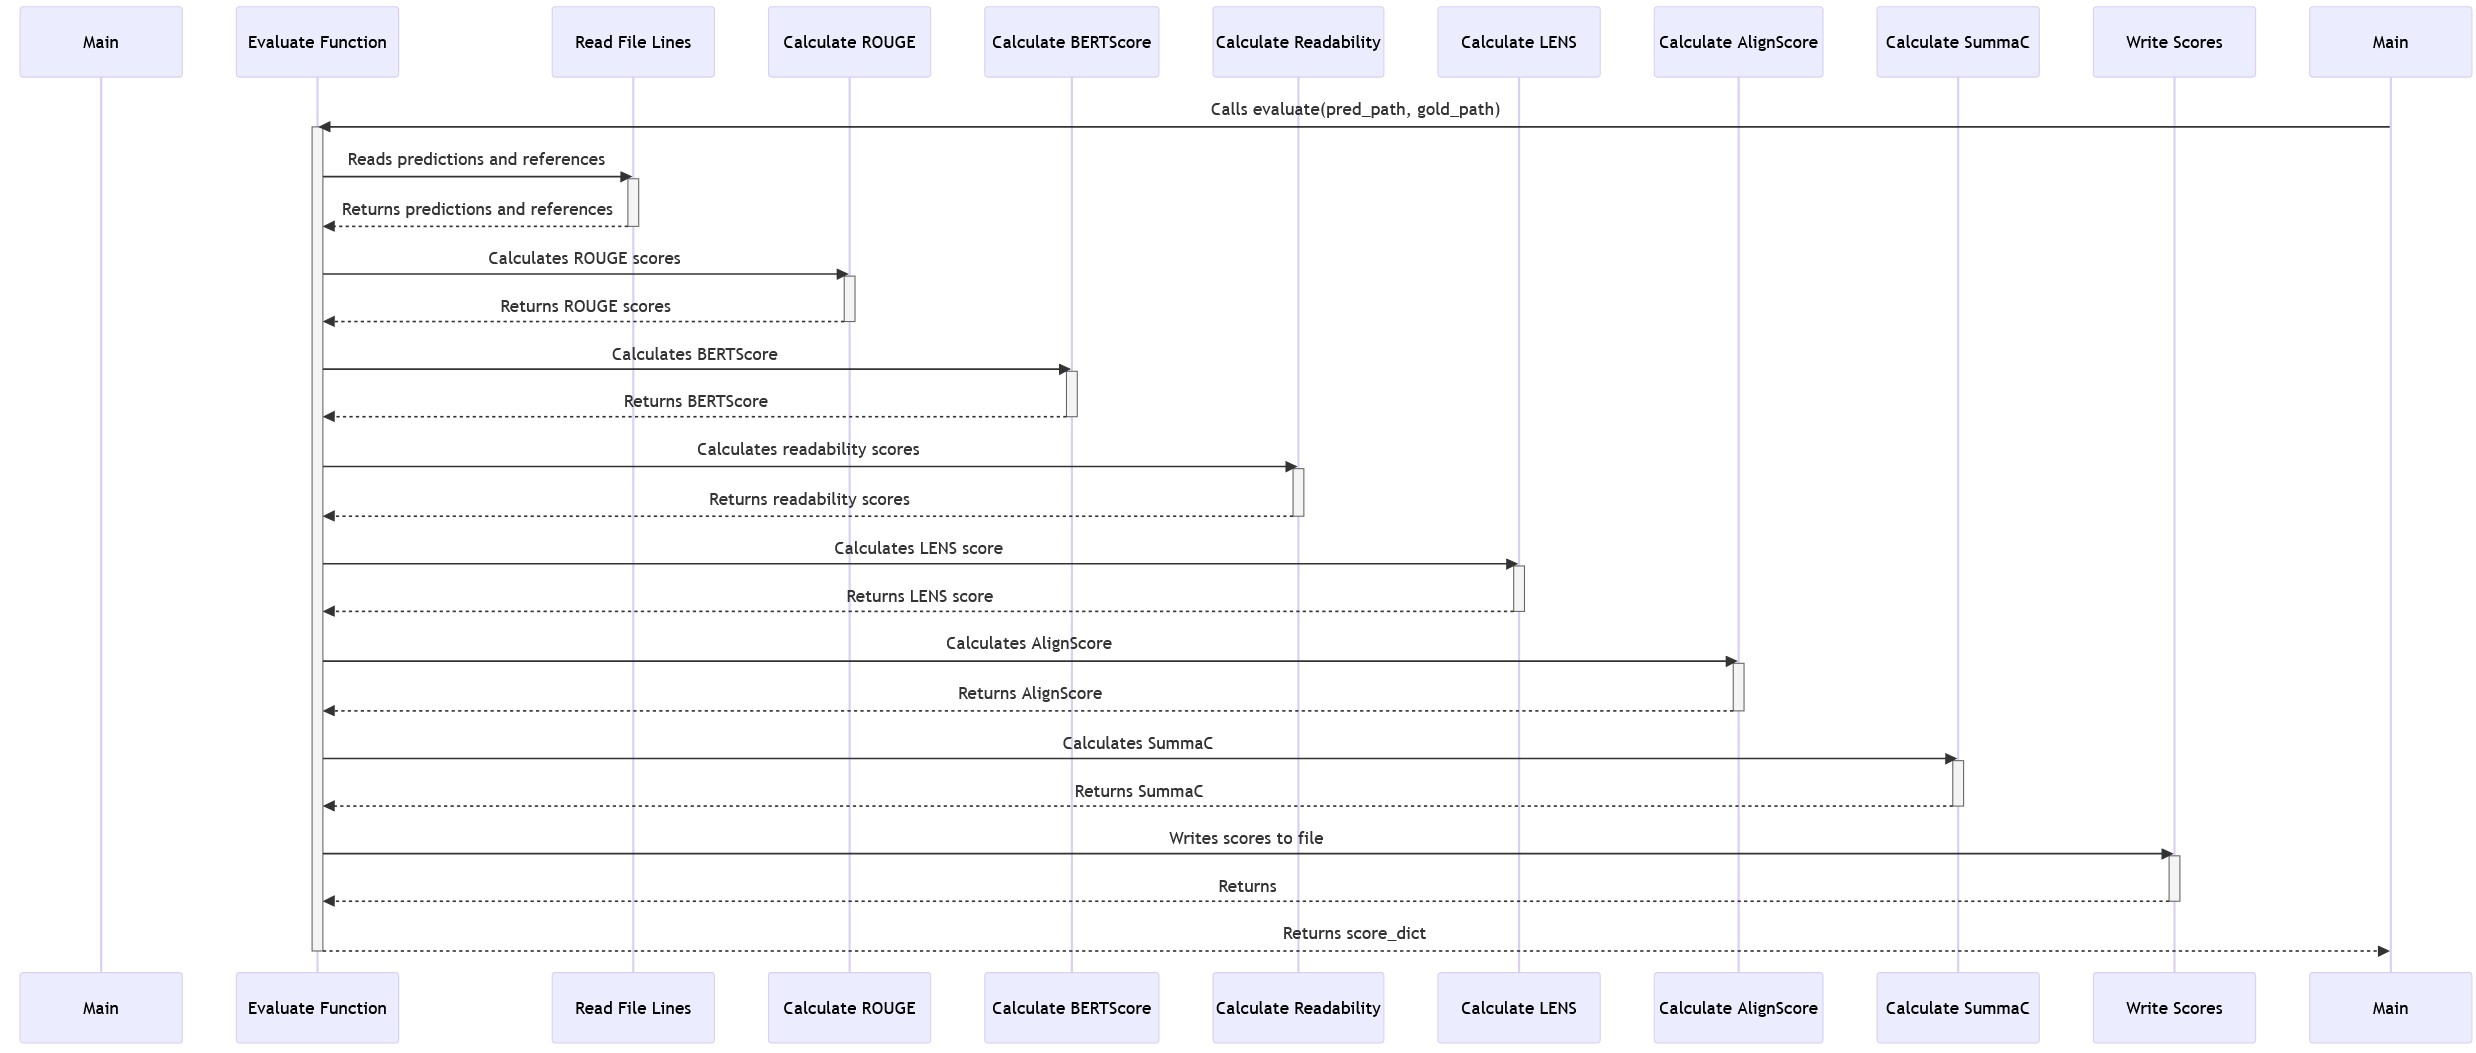